# Zipline algorithm analysis example in pyfolio

Here's an example where we run an algorithm with zipline, then produce tear sheets for that algorithm.

## Imports
Import pyfolio and zipline, and ingest the pricing data for backtesting.

In [1]:
import sys
sys.path.append('/Users/george/Desktop/pyfolio/')

In [ ]:
import pyfolio as pf
%matplotlib inline

# silence warnings
import warnings
warnings.filterwarnings('ignore')

import zipline
%load_ext zipline
!zipline ingest

## Run our zipline algorithm
This algorithm can also be adjusted to execute a modified, or completely different, trading strategy.

In [2]:
%%zipline --start 2004-1-1 --end 2010-1-1 -o results.pickle

# Zipline trading algorithm
# Taken from zipline.examples.olmar

import numpy as np

from zipline.finance import commission, slippage

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0))
    algo.set_slippage(slippage.FixedSlippage(spread=0))


def handle_data(algo, data):
    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    for i, sid in enumerate(algo.sids):
        algo.order_target_percent(sid, desired_port[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2004-01-02 21:00:00+00:00,NaN,0.000000e+00,NaN,-0.000449,NaN,NaN,0.000000e+00,1.000000e+07,0.00,0.00,...,0,0,0,NaN,1.000000e+07,0.00,0.00,1,[],0.0438
2004-01-05 21:00:00+00:00,0.000008,-7.000000e-07,-0.000007,0.010424,0.127153,-0.000062,-1.012625e+07,-1.262475e+05,10126240.51,10126240.51,...,0,0,0,-11.224972,1.000000e+07,0.00,0.00,2,"[{u'commission': None, u'amount': 39332, u'sid...",0.0441
2004-01-06 21:00:00+00:00,0.072177,7.874142e-03,0.941443,0.011413,0.097935,-0.292225,1.098407e+05,-1.640676e+04,10095148.18,10095148.18,...,0,0,0,103096.791454,-1.262475e+05,10126240.51,10126240.51,3,"[{u'commission': None, u'amount': 22673, u'sid...",0.0429
2004-01-07 21:00:00+00:00,0.064694,1.390826e-02,1.158059,0.014827,0.080035,-0.305795,3.809134e+04,2.168458e+04,10117398.03,10117398.03,...,0,0,0,157170.375195,-1.640676e+04,10095148.18,10095148.18,4,"[{u'commission': None, u'amount': 4882, u'sid'...",0.0427
2004-01-08 21:00:00+00:00,0.202046,-1.030250e-02,-0.137563,0.018871,0.069343,-0.388318,1.594916e+04,3.763374e+04,9859341.24,9859341.24,...,0,0,0,-2.978283,2.168458e+04,10117398.03,10117398.03,5,"[{u'commission': None, u'amount': 7020, u'sid'...",0.0427
2004-01-09 21:00:00+00:00,0.181404,-9.874269e-03,-0.290170,0.009975,0.101951,-0.266625,-3.549779e+04,2.135950e+03,9899121.36,9899121.36,...,0,0,0,-2.601355,3.763374e+04,9859341.24,9859341.24,6,"[{u'commission': None, u'amount': 12007, u'sid...",0.0411
2004-01-12 21:00:00+00:00,0.169355,-5.602480e-03,-0.118894,0.017344,0.098995,-0.113533,-3.387390e+03,-1.251440e+03,9945226.64,9945226.64,...,0,0,0,-1.324308,2.135950e+03,9899121.36,9899121.36,7,"[{u'commission': None, u'amount': 879, u'sid':...",0.0411
2004-01-13 21:00:00+00:00,0.162138,-1.366743e-02,-0.454475,0.011503,0.102602,0.090323,-5.892000e+02,-1.840640e+03,9865166.35,9865166.35,...,0,0,0,-2.977973,-1.251440e+03,9945226.64,9945226.64,8,"[{u'commission': None, u'amount': 478, u'sid':...",0.0405
2004-01-14 21:00:00+00:00,0.156543,-8.090471e-03,-0.338686,0.020219,0.103200,0.216209,2.099000e+02,-1.630740e+03,9920726.03,9920726.03,...,0,0,0,-1.621248,-1.840640e+03,9865166.35,9865166.35,9,"[{u'commission': None, u'amount': -958, u'sid'...",0.0401
2004-01-15 21:00:00+00:00,0.147732,-1.021672e-02,-0.370917,0.022466,0.097298,0.216356,-2.985980e+03,-4.616720e+03,9902449.48,9902449.48,...,0,0,0,-1.957694,-1.630740e+03,9920726.03,9920726.03,10,"[{u'commission': None, u'amount': -12547, u'si...",0.0399


## Extract metrics
Get the returns, positions, and transactions from the zipline backtest object.

In [3]:
import pandas as pd

results = pd.read_pickle('results.pickle')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

## Single plot example
Make one plot of the top 5 drawdown periods.

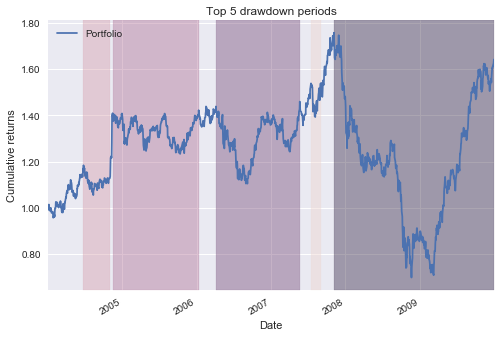

In [4]:
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')

## Full tear sheet example
Create a full tear sheet for our algorithm. As an example, set the live start date to something arbitrary.

/Users/georgeho/pyfolio/pyfolio/utils.py:251: UserWarning: Yahoo Finance read failed: HTTPConnectionPool(host='ichart.finance.yahoo.com', port=80): Max retries exceeded with url: /table.csv?a=0&ignore=.csv&s=SPY&b=1&e=13&d=7&g=d&f=2017&c=1970 (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x12372a750>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',)), falling back to Google
  UserWarning)


Entire data start date: 2004-01-02
Entire data end date: 2009-12-31
In-sample months: 69
Out-of-sample months: 2


,All,In-sample,Out-of-sample
Annual return,8.3%,8.1%,14.9%
Cumulative returns,61.1%,56.8%,2.7%
Annual volatility,25.6%,25.7%,22.0%
Sharpe ratio,0.44,0.43,0.74
Calmar ratio,0.14,0.13,2.03
Stability,0.00,0.01,0.04
Max drawdown,-60.3%,-60.3%,-7.3%
Omega ratio,1.08,1.08,1.13
Sortino ratio,0.64,0.63,1.04
Skew,0.21,0.22,-0.29


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,60.30,2007-11-06,2008-11-20,NaT,NaN
1,23.25,2006-04-06,2006-09-07,2007-05-22,294
2,12.52,2004-11-15,2005-10-12,2006-01-11,303
3,10.90,2004-06-25,2004-08-12,2004-11-04,95
4,9.47,2007-07-16,2007-08-06,2007-09-04,37


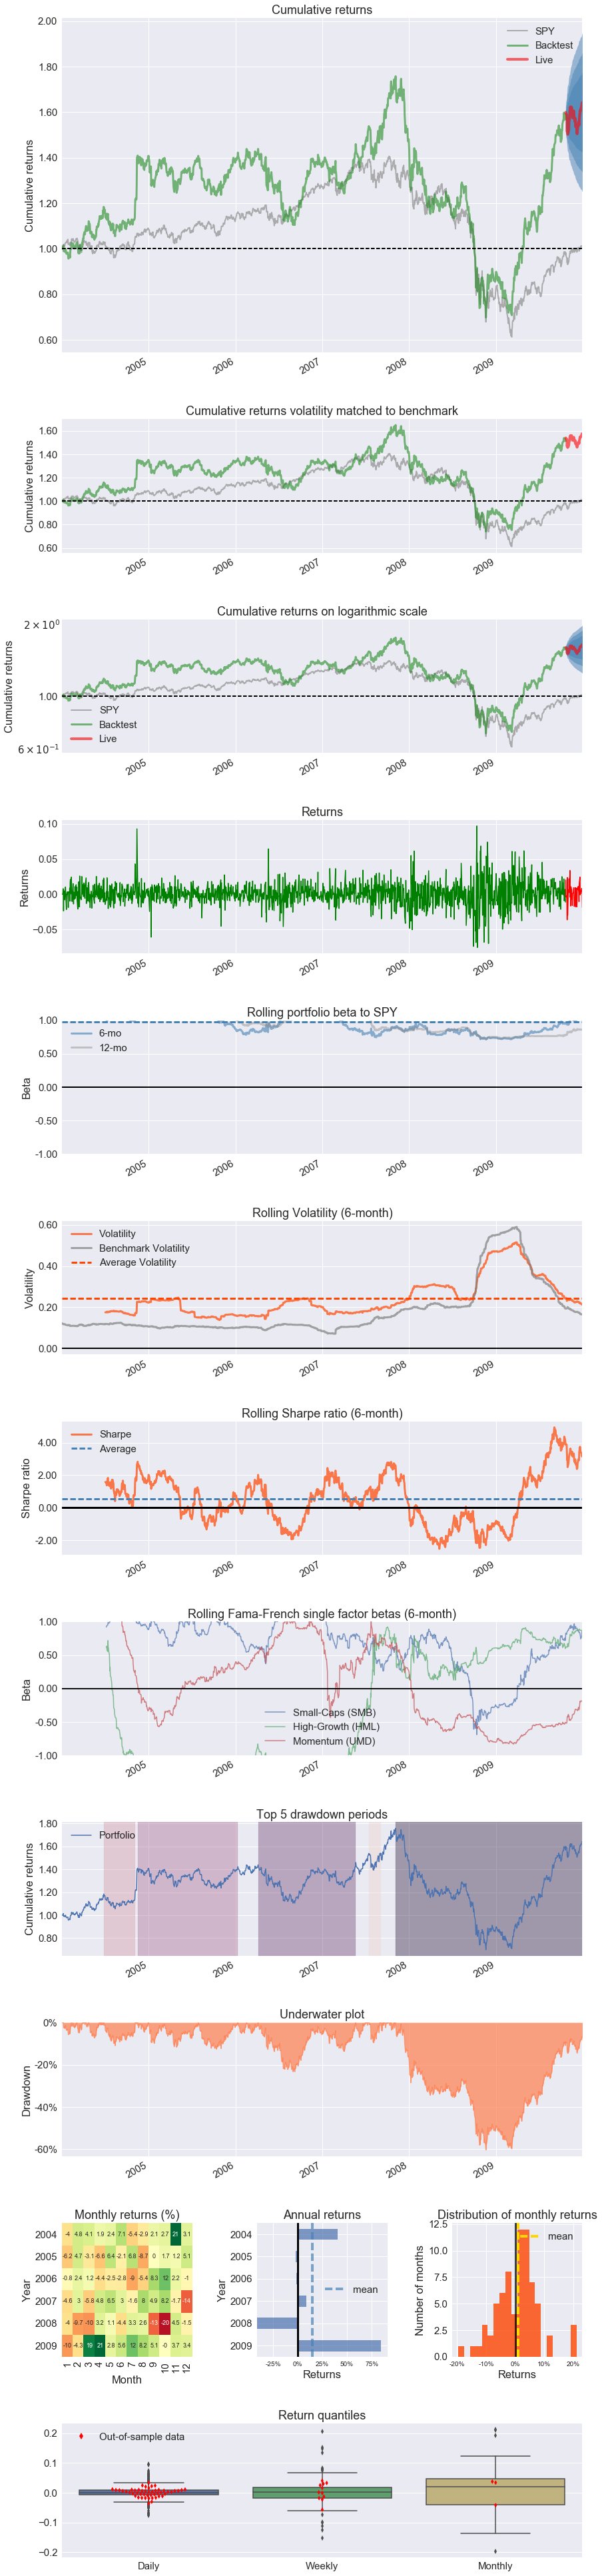

/Users/georgeho/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:4269: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Stress Events,mean,min,max
Lehmann,-0.28%,-7.41%,4.40%
Aug07,0.35%,-2.96%,3.03%
Mar08,-0.43%,-3.10%,3.34%
Sept08,-0.68%,-7.41%,3.99%
2009Q1,-0.35%,-4.98%,3.36%
2009Q2,0.71%,-3.78%,6.17%
Low Volatility Bull Market,0.01%,-6.11%,6.45%
GFC Crash,-0.08%,-7.58%,9.71%
Recovery,0.32%,-3.78%,6.17%


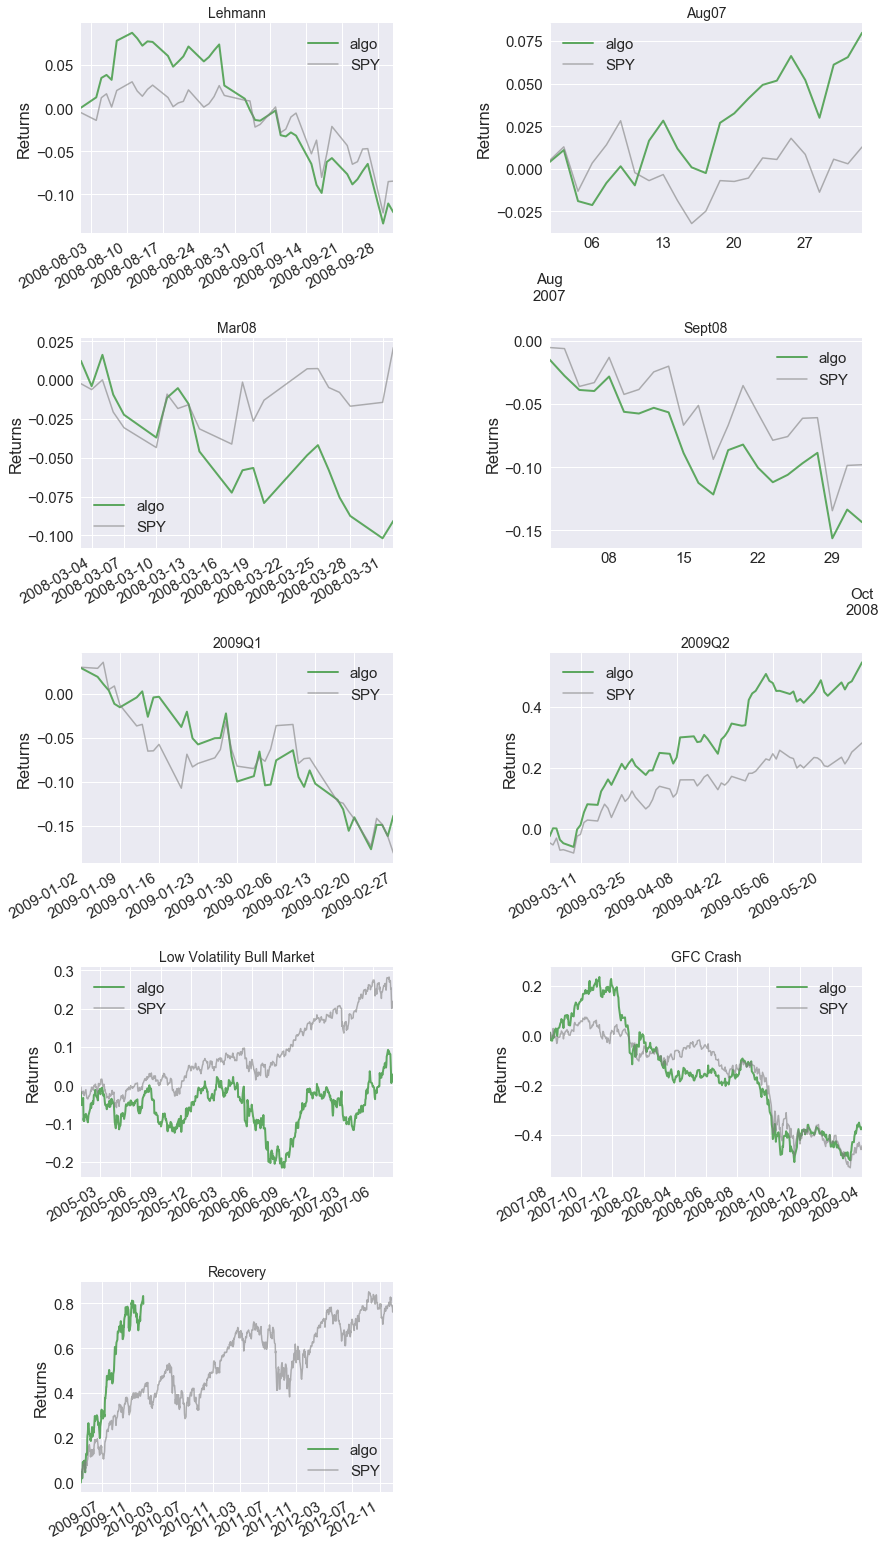

Top 10 long positions of all time,max
COST,100.74%
MMM,92.35%
CERN,84.47%
DELL,72.76%
AMD,71.05%
INTC,69.19%
GPS,62.11%


Top 10 short positions of all time,max


Top 10 positions of all time,max
COST,100.74%
MMM,92.35%
CERN,84.47%
DELL,72.76%
AMD,71.05%
INTC,69.19%
GPS,62.11%


All positions ever held,max
COST,100.74%
MMM,92.35%
CERN,84.47%
DELL,72.76%
AMD,71.05%
INTC,69.19%
GPS,62.11%


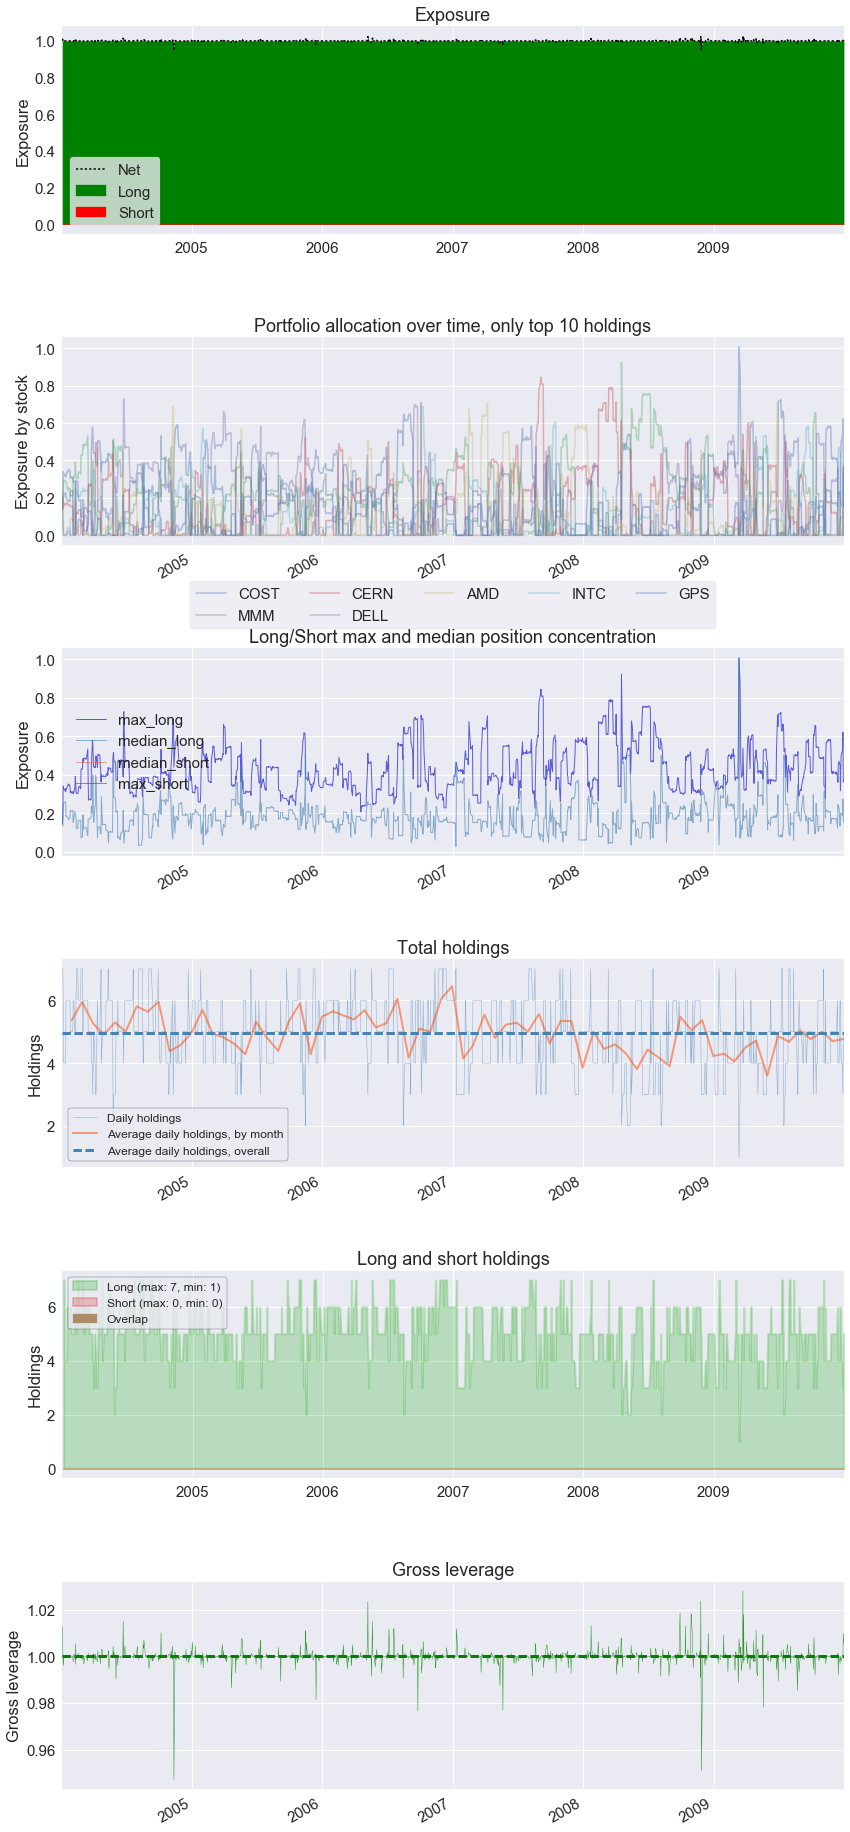

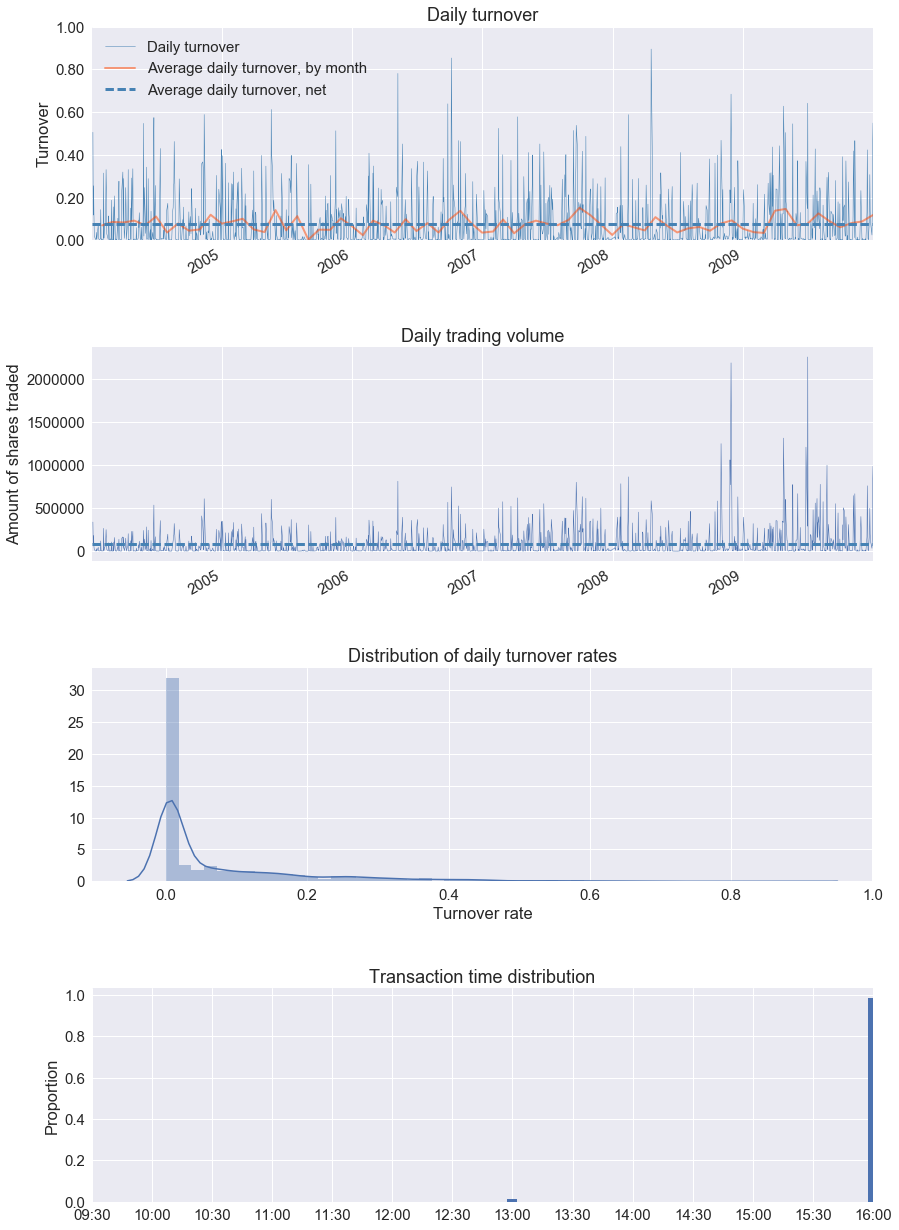

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,3986.00,3.00,3983.00
Percent profitable,0.49,0.33,0.49
Winning round_trips,1938.00,1.00,1937.00
Losing round_trips,2039.00,0.00,2039.00
Even round_trips,9.00,2.00,7.00


PnL stats,All trades,Short trades,Long trades
Total profit,$6118150.70,$0.00,$6118150.70
Gross profit,$37872903.48,$0.00,$37872903.48
Gross loss,$-31754752.78,$0.00,$-31754752.78
Profit factor,$1.19,$nan,$1.19
Avg. trade net profit,$1534.91,$0.00,$1536.07
Avg. winning trade,$19542.26,$0.00,$19552.35
Avg. losing trade,$-15573.69,$nan,$-15573.69
Ratio Avg. Win:Avg. Loss,$1.25,$nan,$1.26
Largest winning trade,$1553000.44,$0.00,$1553000.44
Largest losing trade,$-1251993.38,$0.00,$-1251993.38


Duration stats,All trades,Short trades,Long trades
Avg duration,21 days 18:52:41.966884,20:59:59,21 days 19:15:22.822746
Median duration,17 days 23:00:00,20:59:59,18 days 00:00:00
Longest duration,109 days 01:00:00,20:59:59,109 days 01:00:00
Shortest duration,0 days 03:00:01,20:59:59,0 days 03:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.01%,0.00%,0.01%
Avg returns winning,0.16%,0.00%,0.16%
Avg returns losing,-0.13%,nan%,-0.13%
Median returns all round_trips,-0.00%,0.00%,-0.00%
Median returns winning,0.02%,0.00%,0.02%
Median returns losing,-0.01%,nan%,-0.01%
Largest winning trade,12.13%,0.00%,12.13%
Largest losing trade,-9.14%,0.00%,-9.14%


Symbol stats,CERN,COST,GPS,INTC,MMM,AMD,DELL
Avg returns all round_trips,0.03%,0.03%,-0.01%,0.04%,0.01%,-0.00%,-0.03%
Avg returns winning,0.19%,0.12%,0.13%,0.15%,0.10%,0.36%,0.13%
Avg returns losing,-0.16%,-0.06%,-0.11%,-0.06%,-0.08%,-0.34%,-0.19%
Median returns all round_trips,0.00%,0.00%,-0.00%,-0.00%,-0.00%,-0.00%,-0.00%
Median returns winning,0.02%,0.01%,0.02%,0.03%,0.01%,0.07%,0.01%
Median returns losing,-0.01%,-0.01%,-0.01%,-0.00%,-0.01%,-0.02%,-0.01%
Largest winning trade,5.94%,2.95%,3.54%,2.33%,2.22%,12.13%,3.36%
Largest losing trade,-4.67%,-3.47%,-8.30%,-4.60%,-4.02%,-9.14%,-6.60%


Profitability (PnL / PnL total) per name,
INTC,45.09%
COST,42.42%
CERN,35.52%
MMM,13.51%
GPS,-2.49%
AMD,-7.15%
DELL,-26.91%


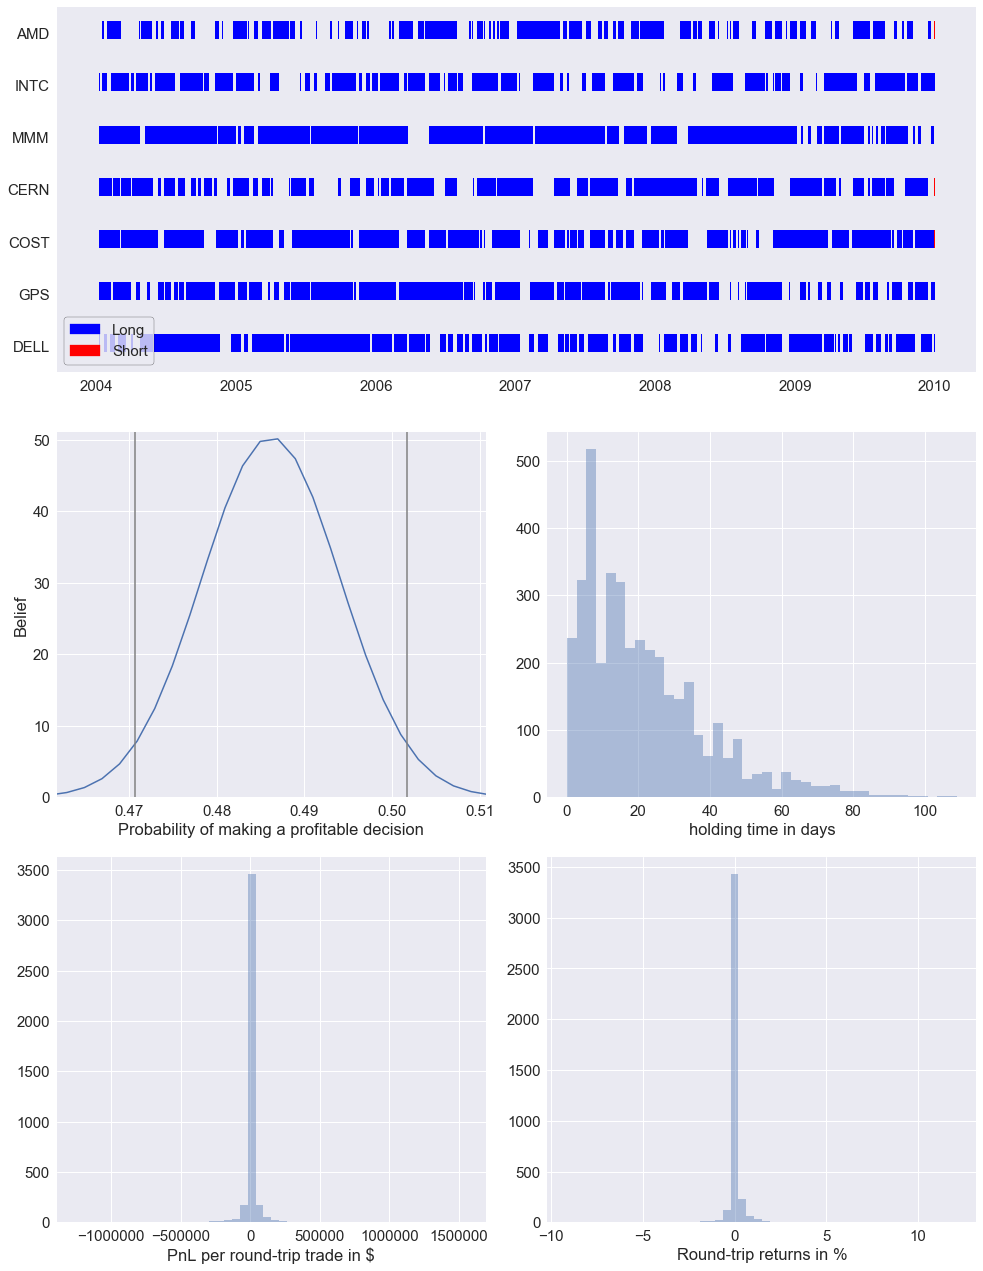

In [5]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', round_trips=True)

## Suppressing symbol output

When sharing tear sheets it might be undesirable to display which symbols where used by a strategy. To suppress these in the tear sheet you can pass `hide_positions=True`.

Entire data start date: 2004-01-02
Entire data end date: 2009-12-31
In-sample months: 69
Out-of-sample months: 2


,All,In-sample,Out-of-sample
Annual return,8.3%,8.1%,14.9%
Cumulative returns,61.1%,56.8%,2.7%
Annual volatility,25.6%,25.7%,22.0%
Sharpe ratio,0.44,0.43,0.74
Calmar ratio,0.14,0.13,2.03
Stability,0.00,0.01,0.04
Max drawdown,-60.3%,-60.3%,-7.3%
Omega ratio,1.08,1.08,1.13
Sortino ratio,0.64,0.63,1.04
Skew,0.21,0.22,-0.29


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,60.30,2007-11-06,2008-11-20,NaT,NaN
1,23.25,2006-04-06,2006-09-07,2007-05-22,294
2,12.52,2004-11-15,2005-10-12,2006-01-11,303
3,10.90,2004-06-25,2004-08-12,2004-11-04,95
4,9.47,2007-07-16,2007-08-06,2007-09-04,37


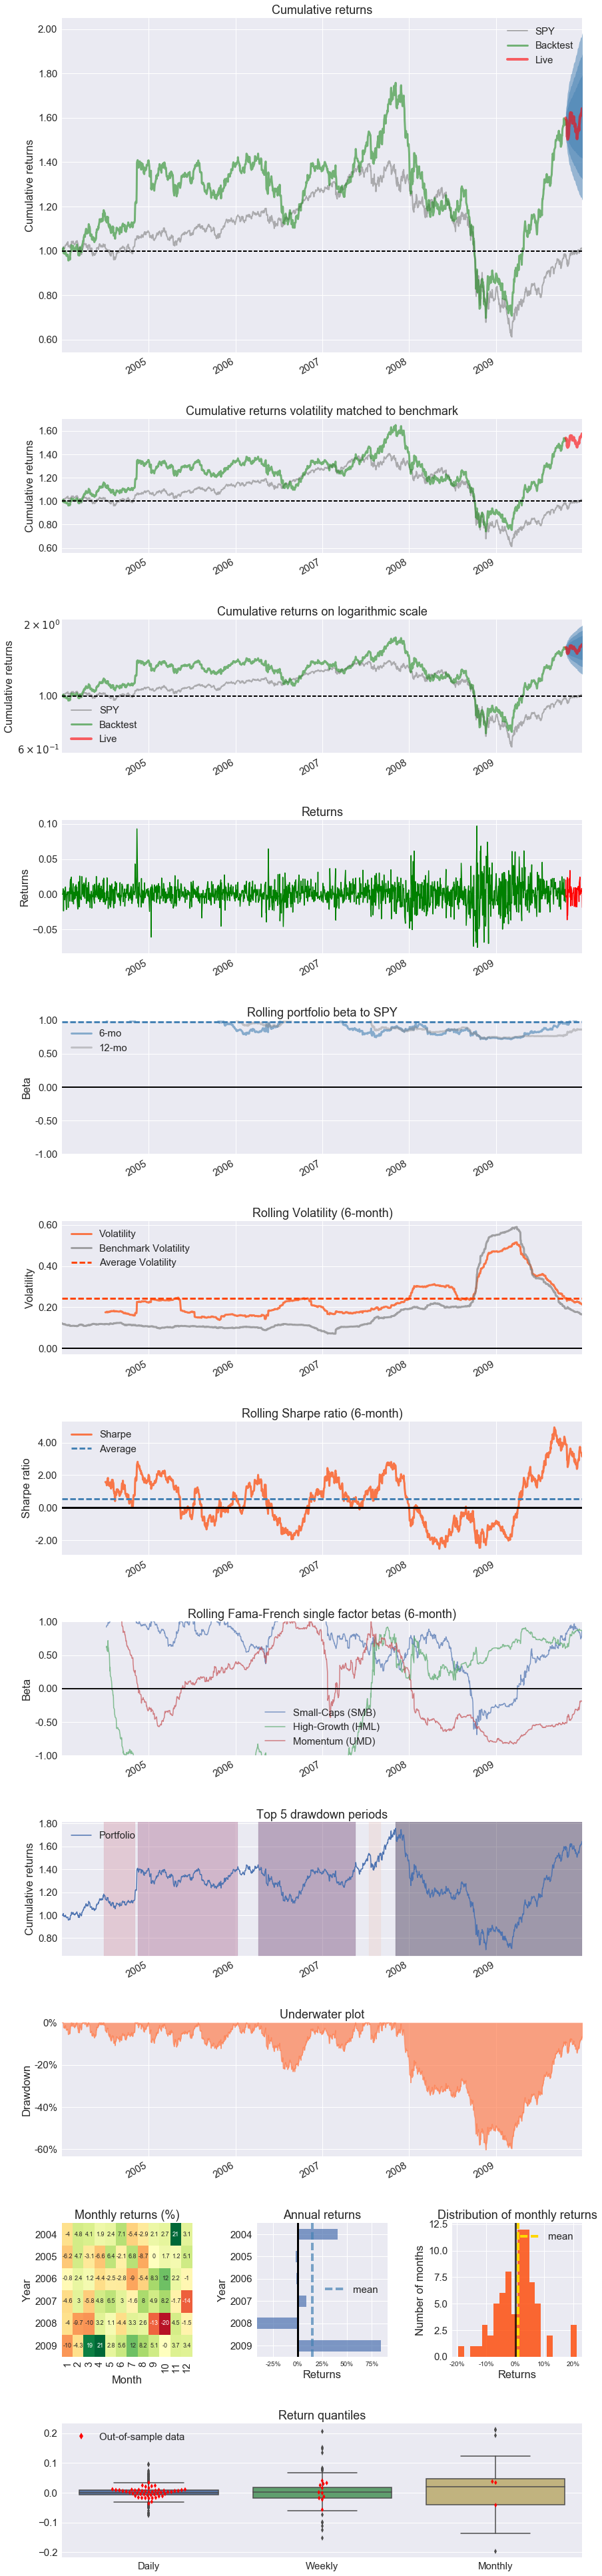

Stress Events,mean,min,max
Lehmann,-0.28%,-7.41%,4.40%
Aug07,0.35%,-2.96%,3.03%
Mar08,-0.43%,-3.10%,3.34%
Sept08,-0.68%,-7.41%,3.99%
2009Q1,-0.35%,-4.98%,3.36%
2009Q2,0.71%,-3.78%,6.17%
Low Volatility Bull Market,0.01%,-6.11%,6.45%
GFC Crash,-0.08%,-7.58%,9.71%
Recovery,0.32%,-3.78%,6.17%


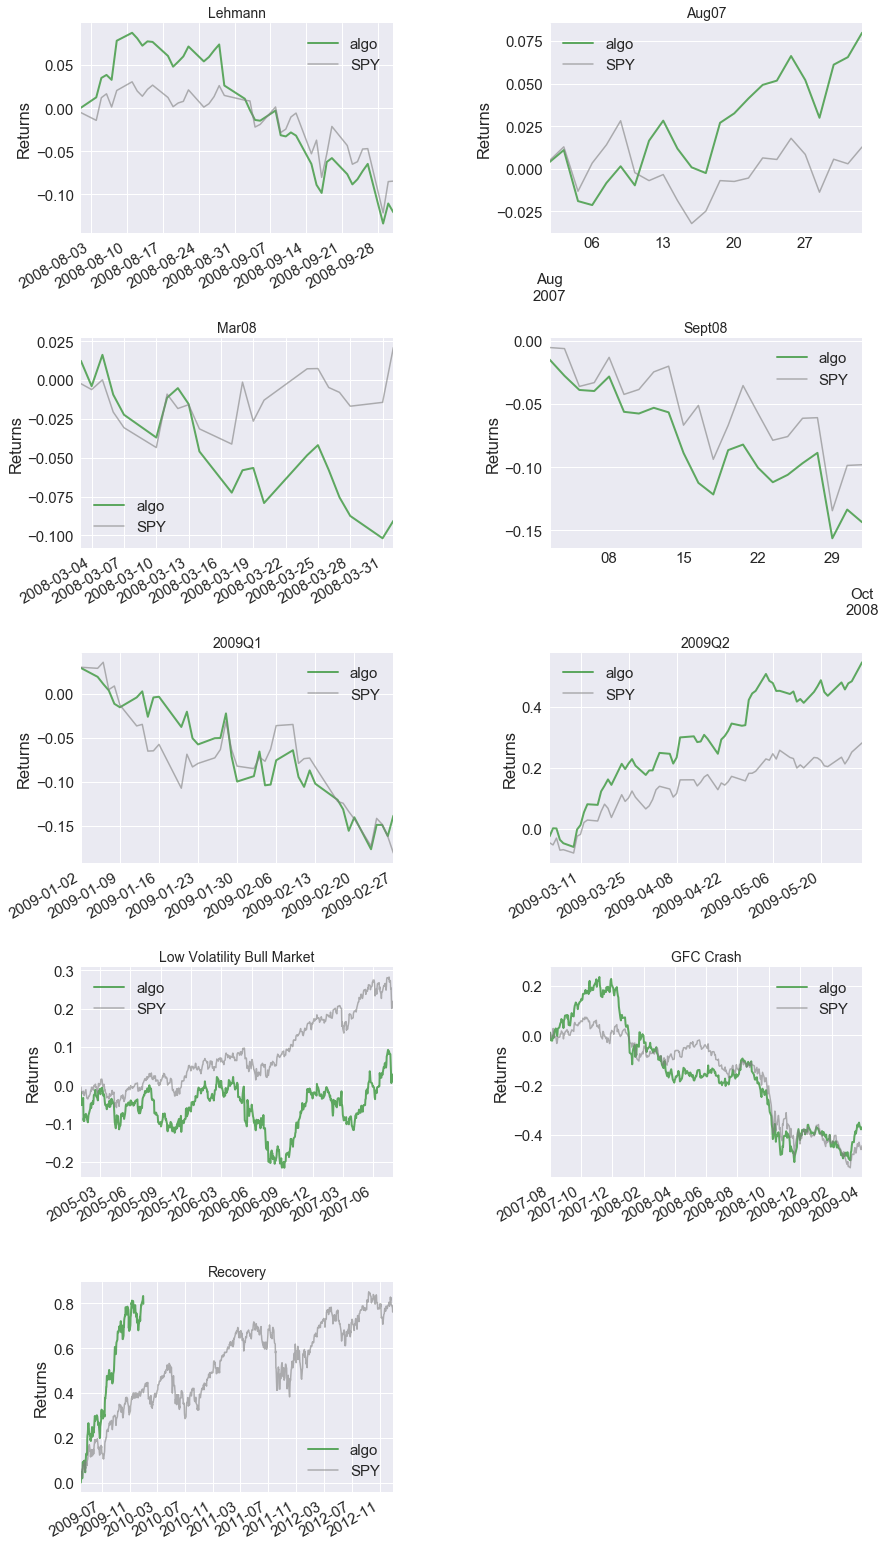

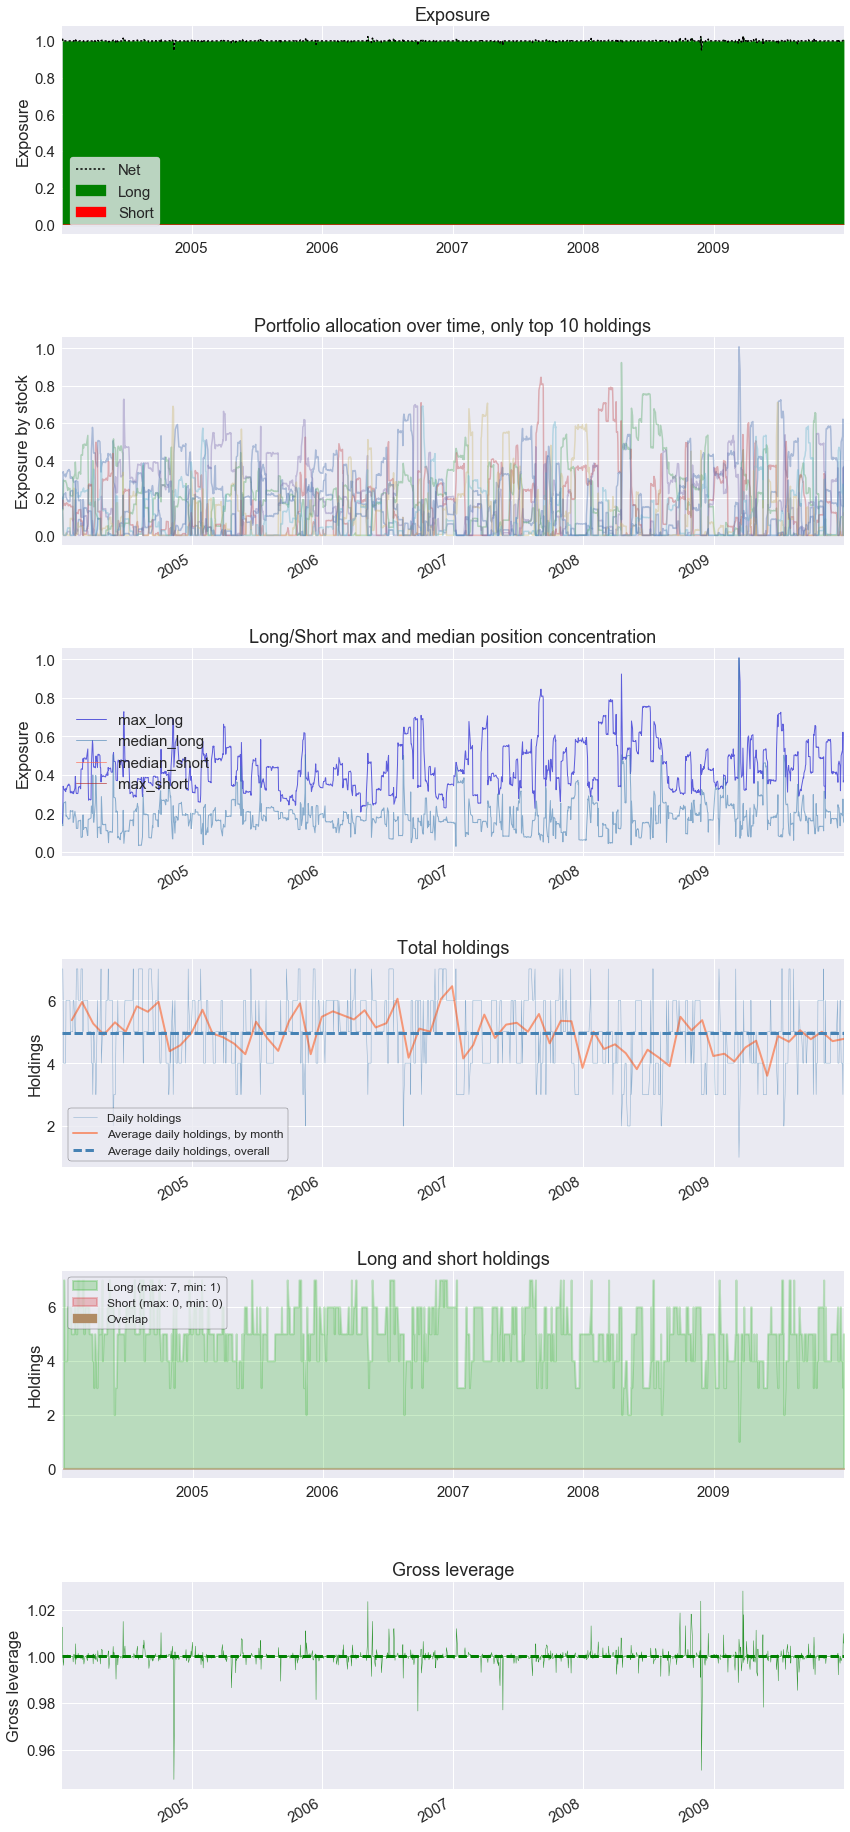

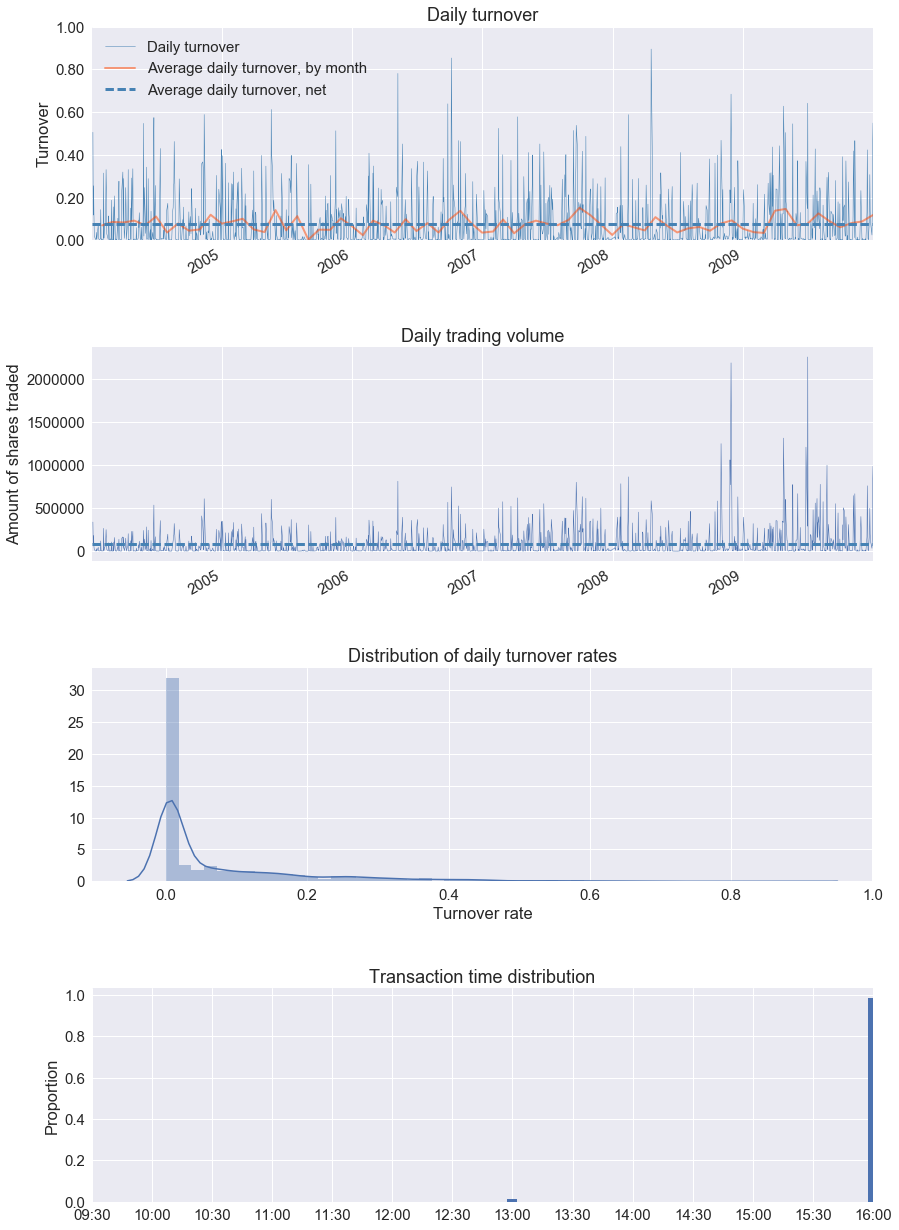

In [6]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2009-10-22', hide_positions=True)